In [25]:
from astropy import coordinates
from PIL import Image
import numpy as np
from astropy import io
import reproject
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
import xarray as xr
from scipy.ndimage import morphology
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator, interp2d, LinearNDInterpolator
from tqdm import tqdm
from astropy import wcs
from astropy.utils.data import download_file
from reproject import reproject_interp
import glob

OK, let's build a png that goes over some range of l and b

In [26]:
lmin = 9
lmax = 40
bmin = -0.8
bmax = 0.8
dpix = 2.0 # arcseconds
ny = int((bmax-bmin)*3600/dpix)
nx = int((lmax-lmin)*3600/dpix)
img_array = np.zeros([ny,nx])

Want to make this into a HDU so that I can use reproject

In [27]:
hduimg = io.fits.PrimaryHDU(img_array)
hduimg.header['CTYPE1']='GLON-SIN'
hduimg.header['CTYPE2']='GLAT-SIN'

hduimg.header['CRVAL1']= 0.5*(lmin+lmax)
hduimg.header['CRPIX1']= nx/2.0
hduimg.header['CROTA1']= 0
hduimg.header['CDELT1']= -1*dpix/3600.

hduimg.header['CRVAL2']= 0.0
hduimg.header['CRPIX2']= ny/2.0
hduimg.header['CROTA2']= 0
hduimg.header['CDELT2']= 1*dpix/3600.

hduimg.header


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                55800                                                  
NAXIS2  =                 2880                                                  
EXTEND  =                    T                                                  
CTYPE1  = 'GLON-SIN'                                                            
CTYPE2  = 'GLAT-SIN'                                                            
CRVAL1  =                 24.5                                                  
CRPIX1  =              27900.0                                                  
CROTA1  =                    0                                                  
CDELT1  = -0.00055555555555555                                                  
CRVAL2  =                  0

OK, let's try to populate the above with data from MAGPIS

In [28]:
from astropy.io import ascii
tab = ascii.read('gps20new_fldinfo.list')
print(tab)

 Name  UserID Dsk Cat#     Long        Lat      NX   NY   PixSize       Freq    
------ ------ --- ---- ----------- ----------- ---- ---- ---------- ------------
070-00    114   3    1  7.32028191 -0.22416725 8192 2048 2.00000005 1410000000.0
070+00    114   3    2  7.32028145  0.20194487 8192 2048 2.00000005 1410000000.0
110-00    114   3    3  11.2202479 -0.22083388 8192 2048 2.00000005 1410000000.0
110+00    114   3    4 11.22024749  0.22861171 8192 2048 2.00000005 1410000000.0
130-00    114   3    5 12.78030769 -0.22083388 8192 2048 2.00000005 1410000000.0
130+00    114   3    6 12.78030811  0.22861171 8192 2048 2.00000005 1410000000.0
160-00    114   3    7  16.2202479 -0.22083388 8192 2048 2.00000005 1410000000.0
160+00    114   3    8 16.22024749  0.22861171 8192 2048 2.00000005 1410000000.0
180-00    114   3    9 17.78030769 -0.22083388 8192 2048 2.00000005 1410000000.0
180+00    114   3   10 17.78030799  0.22638948 8192 2048 2.00000005 1410000000.0
   ...    ... ...  ...      

In [29]:
ls = (tab['Long'].data)
bs = (tab['Lat'].data)
print(bs)
print(ls)

[-0.22416725  0.20194487 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171 -0.22083388  0.22638948 -0.22083388  0.22638948
 -0.22083388  0.22861171 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171 -0.22083388  0.22861171 -0.22083388  0.22861171
 -0.22083388  0.22861171]
[  7.32028191   7.32028145  11.2202479   11.22024749  12.78030769
  12.78030811  16.2202479   16.22024749  17.78030769  17.78030799
  21.2202479   21.22024761  22.78030769  22.78030811  26.2202479
  26.22024749  27.78030769  27.78030811  31.2202479   31.22024749
  32.78030769  32.78030811  36.2202479   36.22024749  37.78030769
  37.78030811  41.2202479   41.22024749  42.78030769  42.78030811
  46.2202479   46.22024749]


In [30]:
import time
t0 = time.time()
#ax1 = plt.subplot(1,1,1, projection=wcs.WCS(hduimg.header))
for j, b in enumerate(tqdm(bs)):
    l = ls[j]
    fn = 'https://third.ucllnl.org/cgi-bin/gpsimage?RA={}&Dec={}&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1'.format(l,b)
    print(fn)
    image_file = download_file(fn, cache=True)
    magpishdu = io.fits.open(image_file)
    for key in ('CTYPE3','CRVAL3','CDELT3','CROTA3','CRPIX3','DATATYPE',
                'DATE','COMMENT','FIELDNAM','OBJECT','OBJCTLON','OBJCTLAT',
                'OBJCTX','OBJCTY','XCORN','YCORN','TELESCOP','INSTRUME',
                'OBSERVER','DATE-OBS','DATE-MAP','BUNIT','EPOCH','EQUINOX',
                'DATAMAX','DATAMIN','BMAJ','BMIN','BPA','HISTORY'):
        del magpishdu[0].header[key]
    array, footprint = reproject_interp(magpishdu[0], hduimg.header)
    if b < 0:
        array[array.shape[0]/2:, :] = np.nan
    if b > 0:
        array[0:array.shape[0]/2, :] = np.nan
    img_array = np.nanmean(np.array([img_array, array]), axis=0)
    #ax1 = plt.subplot(len(bs),len(ls),q, projection=wcs.WCS(hduimg.header))
    #ax1.imshow(array, origin='lower')
    #q = q + 1

print("Completed in {} s".format(time.time()-t0))

|----------| 0/32   0% [elapsed: 00:00 left: ?, ? iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=7.32028191&Dec=-0.22416725&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|----------| 1/32   3% [elapsed: 03:07 left: 1:36:45,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=7.32028145&Dec=0.20194487&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|----------| 2/32   6% [elapsed: 06:21 left: 1:35:18,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=11.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|----------| 3/32   9% [elapsed: 09:30 left: 1:31:57,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=11.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#---------| 4/32  12% [elapsed: 12:46 left: 1:29:26,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=12.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#---------| 5/32  15% [elapsed: 16:04 left: 1:26:50,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=12.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#---------| 6/32  18% [elapsed: 19:22 left: 1:23:58,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=16.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|##--------| 7/32  21% [elapsed: 22:42 left: 1:21:06,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=16.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|##--------| 8/32  25% [elapsed: 26:09 left: 1:18:27,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=17.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|##--------| 9/32  28% [elapsed: 29:17 left: 1:14:52,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=17.78030799&Dec=0.22638948&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|###-------| 10/32  31% [elapsed: 32:34 left: 1:11:40,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=21.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|###-------| 11/32  34% [elapsed: 35:45 left: 1:08:15,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=21.22024761&Dec=0.22638948&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|###-------| 12/32  37% [elapsed: 38:59 left: 1:04:58,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=22.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|####------| 13/32  40% [elapsed: 42:19 left: 1:01:52,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=22.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|####------| 14/32  43% [elapsed: 45:37 left: 58:39,  0.01 iters/sec]  

https://third.ucllnl.org/cgi-bin/gpsimage?RA=26.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|####------| 15/32  46% [elapsed: 48:47 left: 55:18,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=26.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#####-----| 16/32  50% [elapsed: 52:02 left: 52:02,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=27.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#####-----| 17/32  53% [elapsed: 55:15 left: 48:45,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=27.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#####-----| 18/32  56% [elapsed: 58:35 left: 45:33,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=31.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#####-----| 19/32  59% [elapsed: 1:01:57 left: 42:23,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=31.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|######----| 20/32  62% [elapsed: 1:05:10 left: 39:06,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=32.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|######----| 21/32  65% [elapsed: 1:08:34 left: 35:55,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=32.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|######----| 22/32  68% [elapsed: 1:12:02 left: 32:44,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=36.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#######---| 23/32  71% [elapsed: 1:15:17 left: 29:27,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=36.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#######---| 24/32  75% [elapsed: 1:18:43 left: 26:14,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=37.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#######---| 25/32  78% [elapsed: 1:22:01 left: 22:58,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=37.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|########--| 26/32  81% [elapsed: 1:25:26 left: 19:43,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=41.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|########--| 27/32  84% [elapsed: 1:28:49 left: 16:26,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=41.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|########--| 28/32  87% [elapsed: 1:32:14 left: 13:10,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=42.78030769&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#########-| 29/32  90% [elapsed: 1:35:27 left: 09:52,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=42.78030811&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#########-| 30/32  93% [elapsed: 1:38:40 left: 06:34,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=46.2202479&Dec=-0.22083388&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
|#########-| 31/32  96% [elapsed: 1:41:53 left: 03:17,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=46.22024749&Dec=0.22861171&Equinox=Galactic&ImageSize=273.0666&MaxImSize=8192&Survey=gps20new&FITS=1


/Users/jegpeek/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
                                                                       

Completed in 6311.510675907135 s


In [31]:
wiselist = glob.glob('wise*')
wimg_array = np.zeros((ny,nx),dtype=np.float)
wimg_count = np.zeros((ny,nx),dtype=np.int)

for wisefile in tqdm(wiselist):
    wisehdu = io.fits.open(wisefile)
    array, footprint = reproject_interp(wisehdu['clean image'], hduimg.header)
    wok = np.where(np.isfinite(array) & (array != 0))
    wimg_array[wok] = wimg_array[wok] + array[wok]
    wimg_count[wok] += 1
wimg_array = wimg_array/wimg_count.clip(1)

print("Completed in {} s".format(time.time()-t0))



Completed in 8201.875252962112 s


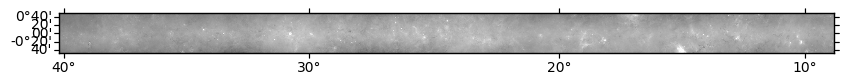

In [32]:
plt.figure(figsize=[10, 5])
ax1 = plt.subplot(1,1,1, projection=wcs.WCS(hduimg.header))
ax1.imshow(np.arcsinh(wimg_array/1e-3), origin='lower', cmap='gray')

In [33]:
color_array = np.zeros([ny, nx, 3])
wmedian = np.median(wimg_array)
wrms = np.median(np.abs(wimg_array-wmedian))*1.486
rrms = np.median(np.abs(img_array))*1.486
print("WISE rms",wrms,"Radio rms",rrms)
# color_array[:, :, 0] = np.arcsinh(arraywise/wrms)/np.arcsinh(arraywise.max()/wrms)
# color_array[:, :, 2] = (np.arcsinh(img_array/rrms)/np.arcsinh(img_array.max()/rrms)).clip(0.0)
# clip negative pixels at -5 sigma
clipval = np.arcsinh(-5.0)
rr = np.arcsinh((wimg_array-wmedian)/wrms).clip(clipval)
color_array[:, :, 0] = (rr-rr.min())/(rr.max()-rr.min())
rr = np.arcsinh(img_array/rrms).clip(clipval)
color_array[:, :, 2] = (rr-rr.min())/(rr.max()-rr.min())
color_array[:, :, 1] = np.mean(color_array[:,:,::2],axis=-1)

WISE rms 953.23525994 Radio rms 0.000409381619684


## Get GLIMPSE 8.0 $\mu$m Data

In [34]:
gtab = ascii.read('gpsglimpse80_fldinfo.list')
print(gtab)

 Name  UserID Dsk Cat#     Long       Lat       NX   NY   PixSize   Freq
------ ------ --- ---- ----------- ---------- ----- ---- ---------- ----
119-02    117   4    1 12.00027778 0.00027778 11000 3600 2.00000005 -1.0
171-02    117   4    2 17.00027778 0.00027778 11000 3600 2.00000005 -1.0
219-02    117   4    3 22.00027778 0.00027778 11000 3600 2.00000005 -1.0
271-02    117   4    4 27.00027778 0.00027778 11000 3600 2.00000005 -1.0
319-02    117   4    5 32.00027778 0.00027778 11000 3600 2.00000005 -1.0
 G371D    117   4    6 37.10027625 0.00027778 11000 3600 2.00000005 -1.0
 G419D    117   4    7  41.9002793 0.00027778 11000 3600 2.00000005 -1.0
 G471D    117   4    8 47.10027625 0.00027778 11000 3600 2.00000005 -1.0
  G51D    117   4    9 50.99983333 0.00016667  9320 7220 1.19999999 -1.0
  G54D    117   4   10 53.99983333 0.00016667  9320 7220 1.19999999 -1.0
  G57D    117   4   11 56.99983333 0.00016667  9320 7220 1.19999999 -1.0
  G60D    117   4   12 59.99983333 0.00016667  9320

In [35]:
gls = (gtab['Long'].data)
gbs = (gtab['Lat'].data)
print(gbs)
print(gls)

[ 0.00027778  0.00027778  0.00027778  0.00027778  0.00027778  0.00027778
  0.00027778  0.00027778  0.00016667  0.00016667  0.00016667  0.00016667
  0.00016667]
[ 12.00027778  17.00027778  22.00027778  27.00027778  32.00027778
  37.10027625  41.9002793   47.10027625  50.99983333  53.99983333
  56.99983333  59.99983333  62.99983333]


In [36]:
t0 = time.time()
#ax1 = plt.subplot(1,1,1, projection=wcs.WCS(hduimg.header))
gimg_array = np.zeros((ny,nx),dtype=np.float)
gimg_count = np.zeros((ny,nx),dtype=np.int)
for j, b in enumerate(tqdm(gbs)):
    l = gls[j]
    fn = 'https://third.ucllnl.org/cgi-bin/gpsimage?RA={}&Dec={}&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1'.format(l,b)
    print(fn)
    image_file = download_file(fn, cache=True)
    glimpsehdu = io.fits.open(image_file)
    for key in ('CTYPE3','CRVAL3','CDELT3','CROTA3','CRPIX3','DATATYPE',
                'DATE','COMMENT','FIELDNAM','OBJECT','OBJCTLON','OBJCTLAT',
                'OBJCTX','OBJCTY','XCORN','YCORN','TELESCOP','INSTRUME',
                'OBSERVER','DATE-OBS','DATE-MAP','BUNIT','EPOCH','EQUINOX',
                'DATAMAX','DATAMIN','BMAJ','BMIN','BPA','HISTORY'):
        if key in glimpsehdu[0].header:
            del glimpsehdu[0].header[key]
    array, footprint = reproject_interp(glimpsehdu[0], hduimg.header)
    glimpsehdu.close()
    wok = np.where(np.isfinite(array) & (array != 0))
    gimg_array[wok] = gimg_array[wok] + array[wok]
    gimg_count[wok] += 1
gimg_array = gimg_array/gimg_count.clip(1)
print("Completed in {} s".format(time.time()-t0))

|----------| 0/13   0% [elapsed: 00:00 left: ?, ? iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=12.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|----------| 1/13   7% [elapsed: 03:14 left: 38:48,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=17.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|#---------| 2/13  15% [elapsed: 06:06 left: 33:37,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=22.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|##--------| 3/13  23% [elapsed: 08:54 left: 29:42,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=27.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|###-------| 4/13  30% [elapsed: 11:43 left: 26:23,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=32.00027778&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|###-------| 5/13  38% [elapsed: 14:38 left: 23:25,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=37.10027625&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|####------| 6/13  46% [elapsed: 17:35 left: 20:31,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=41.9002793&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|#####-----| 7/13  53% [elapsed: 20:27 left: 17:32,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=47.10027625&Dec=0.00027778&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|######----| 8/13  61% [elapsed: 23:15 left: 14:31,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=50.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|######----| 9/13  69% [elapsed: 25:53 left: 11:30,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=53.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|#######---| 10/13  76% [elapsed: 28:15 left: 08:28,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=56.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|########--| 11/13  84% [elapsed: 30:43 left: 05:35,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=59.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


|#########-| 12/13  92% [elapsed: 33:12 left: 02:46,  0.01 iters/sec]

https://third.ucllnl.org/cgi-bin/gpsimage?RA=62.99983333&Dec=0.00016667&Equinox=Galactic&ImageSize=366.667&MaxImSize=11000&Survey=gpsglimpse80&FITS=1


Completed in 2154.6479058265686 s


In [37]:
color_array = np.zeros([ny, nx, 3])
wmedian = np.median(wimg_array)
wrms = np.median(np.abs(wimg_array-wmedian))*1.486
rrms = np.median(np.abs(img_array))*1.486
gmedian = np.median(gimg_array)
grms = np.median(np.abs(gimg_array-gmedian))*1.486
print("WISE rms",wrms,"Radio rms",rrms,"GLIMPSE rms",grms)
# color_array[:, :, 0] = np.arcsinh(arraywise/wrms)/np.arcsinh(arraywise.max()/wrms)
# color_array[:, :, 2] = (np.arcsinh(img_array/rrms)/np.arcsinh(img_array.max()/rrms)).clip(0.0)
# clip negative pixels at -5 sigma
clipval = np.arcsinh(-5.0)
rr = np.arcsinh((wimg_array-wmedian)/wrms).clip(clipval)
color_array[:, :, 0] = (rr-rr.min())/(rr.max()-rr.min())
rr = np.arcsinh((gimg_array-gmedian)/grms).clip(clipval)
color_array[:, :, 1] = (rr-rr.min())/(rr.max()-rr.min())
rr = np.arcsinh(img_array/rrms).clip(clipval)
color_array[:, :, 2] = (rr-rr.min())/(rr.max()-rr.min())

WISE rms 953.23525994 Radio rms 0.000409381619684 GLIMPSE rms 27.8675607599


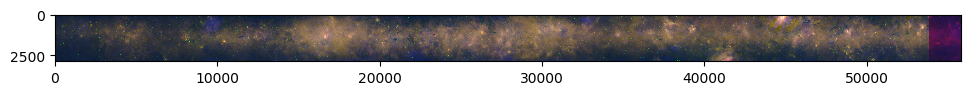

In [38]:
plt.figure(figsize=[12, 12.*color_array.shape[0]/color_array.shape[1]])
plt.imshow(color_array)

In [39]:
img = Image.fromarray(np.uint8(color_array*255), 'RGB')

In [40]:
img.save('test3.png')

Lupton et al. 2004 is ugly!

In [41]:
lupton_array = np.zeros([2880, 9000, 3])
wmedian = np.median(arraywise)
wrms = np.median(np.abs(arraywise-wmedian))*1.486
rmedian = np.median(img_array)
rrms = np.median(np.abs(img_array))*1.486
gmedian = np.median(gimg_array)
grms = np.median(np.abs(gimg_array-gmedian))*1.486
print("WISE rms",wrms,"Radio rms",rrms,"GLIMPSE rms",grms)

wscale = (arraywise-wmedian)/wrms
gscale = (gimg_array-gmedian)/grms
rscale = (img_array)/rrms

lupton_i = (wscale-np.min(wscale) + gscale-np.min(gscale) + rscale-np.min(rscale))/3.0

xx = np.arcsinh(lupton_i).clip(clipval)
f_lupi = (xx-xx.min())/(xx.max()-xx.min())

lupton_array[:, :, 0] = f_lupi*(wscale-np.min(wscale))/lupton_i
lupton_array[:, :, 1] = f_lupi*(gscale-np.min(gscale))/lupton_i
lupton_array[:, :, 2] = f_lupi*(rscale-np.min(rscale))/lupton_i

plt.figure(figsize=[12, 12.*color_array.shape[0]/color_array.shape[1]])
plt.imshow(lupton_array)


NameError: name 'arraywise' is not defined

In [ ]:
import glob
dirlist = glob.glob('wise*')

In [ ]:
dirlist